In [1]:
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import warnings

import os
import glob
from contextlib import contextmanager
import rasterio
import numpy as np



@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

c:\Users\alanb\anaconda3\envs\cloud-d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Adquirir imagens Awa

In [2]:
with cwd('../Imagens/awa'):
    imagens = sorted(os.listdir())
    caminho = os.path.join(imagens[1], 'GRANULE')
    with cwd(caminho):
        l1c = os.listdir()[0] # Escolher apenas a primeira imagem
        with cwd(os.path.join(l1c, 'IMG_DATA')):
            bandas = sorted(os.listdir())
            banda_b = rasterio.open([b for b in bandas if 'B02' in b][0]).read(1)  # Blue
            banda_g = rasterio.open([b for b in bandas if 'B03' in b][0]).read(1)  # Green
            banda_r = rasterio.open([b for b in bandas if 'B04' in b][0]).read(1)  # Red

# Normaliza os valores das bandas RGB para 0 a 255 e junta em uma imagem

In [3]:
def normalize_band(band, stretch_factor=1.5):
  """
  Normalizes a band and stretches contrast.

  Args:
      band: A numpy array representing the band data.
      stretch_factor: A factor to control the amount of contrast stretching (default: 1.5).

  Returns:
      A numpy array with normalized and stretched band values.
  """
  return ((band - band.min()) / (band.max() - band.min()) * stretch_factor) * 255

b_r = normalize_band(banda_r, stretch_factor=1.5)  # Adjust stretch factor as needed
b_g = normalize_band(banda_g, stretch_factor=1.5)
b_b = normalize_band(banda_b, stretch_factor=1.5)

scaling_factor = 1.5
#rgb_composite_raw = (np.dstack((b_r, b_g, b_b)) * 3.5).clip(0, 1)
# Optionally adjust scaling factor here (e.g., scaling_factor = 2.0)
rgb_composite_raw = np.dstack((b_r * scaling_factor, b_g * scaling_factor, b_b * scaling_factor)).astype(int)
del b_r, b_g, b_b, banda_r, banda_g, banda_b



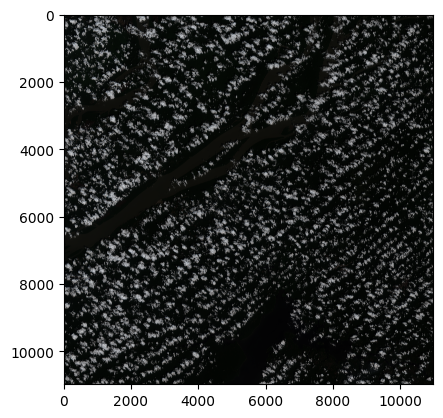

In [4]:
#Visualiza a imagem
plt.imshow(rgb_composite_raw)

In [5]:
#Quebra a imagem em várias imagens de 512 x 512
patch_size = 512
step = 512
patches = view_as_windows(rgb_composite_raw, (patch_size, patch_size, 3), step=step)
patches = patches.reshape(-1, patch_size, patch_size, 3)
del rgb_composite_raw

In [6]:
#Salva as imagens quebradas
output_dir = 'patches_npy'
os.makedirs(output_dir, exist_ok=True)
for i, patch in enumerate(patches):
    np.save(f'{output_dir}/patch_{i}.npy', patch)

# Testes

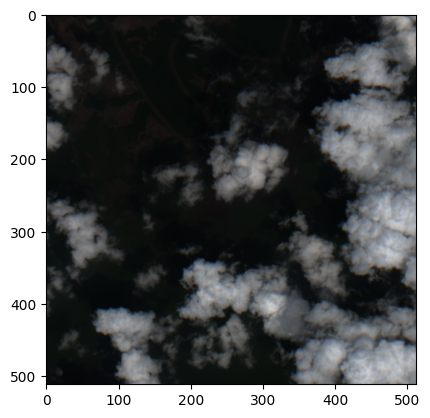

In [7]:
#Lê e visualiza uma das imagens quebradas
patch_path = 'patches_npy/patch_1.npy'
patch = np.load(patch_path)

plt.imshow(patch)

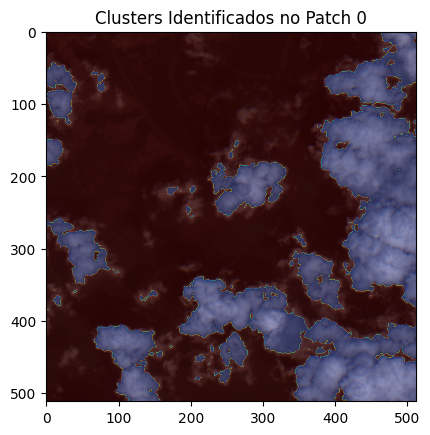

In [8]:
#Testa o algoritmo Kmeans na imagem acima


# Redimensionar o patch para um array 2D onde cada pixel é uma amostra com 3 atributos (RGB)
pixels = patch.reshape(-1, 3)

# Aplicar K-Means com 2 clusters (por exemplo: nuvens e não nuvens)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(pixels)

# Rotular cada pixel com seu cluster correspondente
labels = kmeans.labels_

# Reshape dos labels para a dimensão original da imagem
labels_reshaped = labels.reshape(patch.shape[:2])

# Plotar o resultado da clusterização
plt.imshow(patch)
plt.imshow(labels_reshaped, cmap='jet', alpha=0.3)
plt.title("Clusters Identificados no Patch 0")
plt.show()

In [18]:
#Cria uma classe para separar o dataset em treino, validação e teste já criando as máscaras com o Kmeans.

class CloudDataset(Dataset):
    def __init__(self, patches_dir):
        self.patches_dir = patches_dir
        self.patches = glob.glob(f'{patches_dir}/*.npy')
        self.transform = transforms.Compose([
            transforms.ToTensor()  # Apenas para patches de imagem
        ])

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch_path = self.patches[idx]
        patch = np.load(patch_path)

        # Aplicar K-Means
        pixels = patch.reshape(-1, 3)
        n_clusters = 2
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(pixels)
        labels = kmeans.labels_
        target = labels.reshape(patch.shape[:2])
        target = np.expand_dims(target, axis=0)

        # Verificar formato do patch
        patch = patch.transpose((2, 0, 1))  # Converte de [H, W, C] para [C, H, W]


        # Transformar as imagens
        patch = torch.tensor(patch, dtype=torch.uint8)
        target = torch.tensor(target, dtype=torch.float)  # Convertendo para tensor PyTorch

        return {'image': patch, 'mask' : target}



# Definição do dataset
dataset = CloudDataset('patches_npy')
# Split dataset into training, validation e tests sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#n_cpu = os.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 264
Valid size: 88
Test size: 89


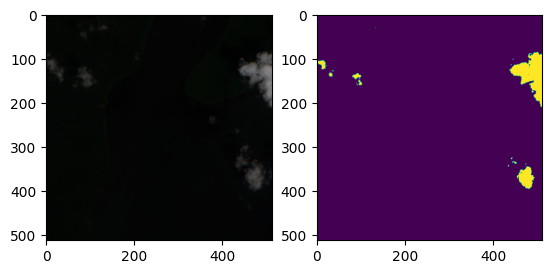

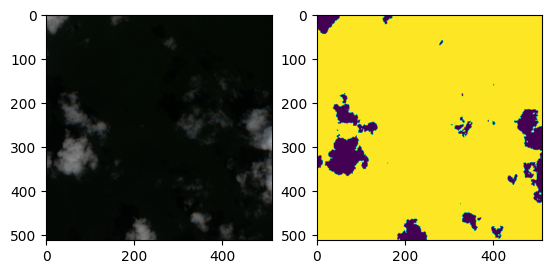

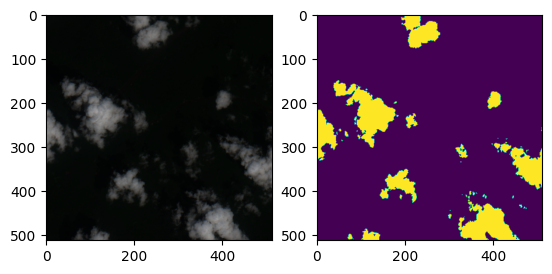

In [10]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
# for visualization we have to transpose back to HWC
plt.imshow(sample['image'].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample['mask'].squeeze())
plt.show()

sample = val_dataset[0]
plt.subplot(1,2,1)
# for visualization we have to transpose back to HWC
plt.imshow(sample['image'].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample['mask'].squeeze())
plt.show()

sample = test_dataset[1]
plt.subplot(1,2,1)
# for visualization we have to transpose back to HWC
plt.imshow(sample['image'].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample['mask'].squeeze())
plt.show()

In [25]:
# Some training hyperparameters
EPOCHS = 20
T_MAX = EPOCHS * len(train_dataset)
OUT_CLASSES = 1

In [26]:
#Classe que implementa a rede neural herdada do LightningModule e utiliza a SMP para iniciar o modelo de rede com pesos pré-treinados

class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []


    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch['image']

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        #print(image.shape)
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch['mask']
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step',
                'frequency': 1
            }
        }
        return

In [ ]:
#Cria uma rede neural
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 358MB/s]


In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)


# Esconder FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#treina a rede neural
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 23.2 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
175       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
smp_model = model.model
# if push_to_hub=True, model will be saved to repository with this name
smp_model.save_pretrained('/content/drive/My Drive/my_model')

In [27]:

model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

In [28]:
# Load the model from the local directory
model.model = smp.from_pretrained('./my_model_FPN_20_Epocas')

Loading weights from local directory


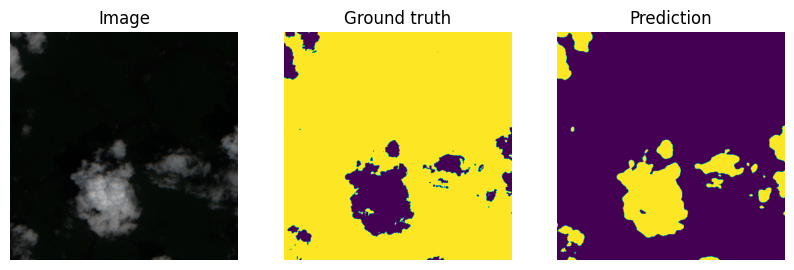

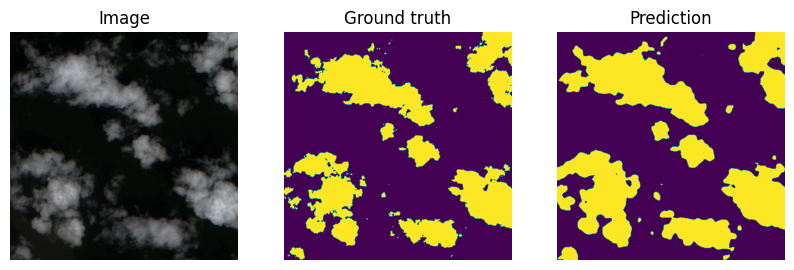

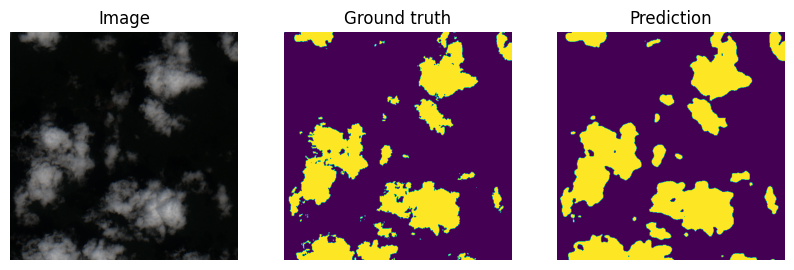

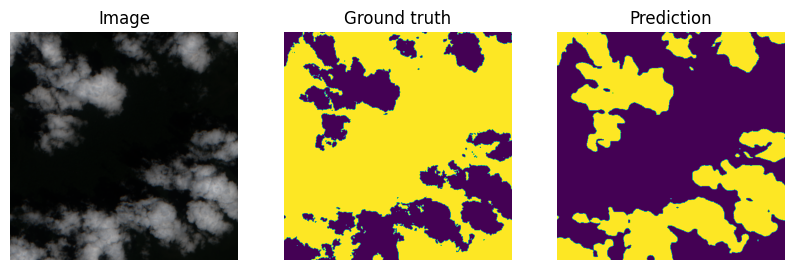

In [31]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch['image'])
pr_masks = logits.sigmoid()
pr_masks = (pr_masks > 0.5).float() 
for idx, (image, gt_mask, pr_mask) in enumerate(zip(batch['image'], batch['mask'], pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break